In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.integrate import quad
from scipy import interpolate
from chain_analysis import contour_plot, gelman_rubin
import time
%matplotlib nbagg
%load_ext autoreload

In [12]:
c=2.99792e5
mu_err = 0.2
fiducial_cos = np.array([0.31, -1, 67.74])

In [3]:
def func(z, om_m, w):
    """Function to integrate in computing d_L"""
    return (om_m*(1+z)**3.0+(1-om_m)*(1+z)**(3*(w+1)))**(-0.5)


def dist(z, om_m, w, H0):
    """Compute distance modulus for an array of redshifts"""
    mu=[]
    for k in range(len(z)):
        y, yerr = quad(func,0.0,z[k],args=(om_m, w))
        d = c*(1.0+z[k])/H0*y
        
        mu.append(5.0*np.log10(d) + 25.0)
    return np.array(mu)

In [131]:
def cos_prior(p):
    """Apply a flat prior to cosmological parameters"""
    bounds = [[0, 1], [-6, 4], [10, 200]]
    for i in range(len(bounds)):
        if p[i]< bounds[i][0] or p[i] > bounds[i][1]:
            return False
    return True

def z_prior(p):
    """Apply a flat prior for all redshifts in array"""
    z_bound = [0, 1.4]
    for i in range(len(p)):
        if p[i]<z_bound[0] or p[i]>z_bound[1]:
            return False
    return True

In [153]:
def lnprob_std(p, dat):
    """
    ln(posterior probability) function. Combines likelihood and prior.
    Parameters
    ----------
    p : list or np.array
        Array of parameters
    dat : np.array
        Data in the form first column redshift, second column mu    

    Returns
    -------
    log(posterior) : float
    
    """
    if not cos_prior(p):
        return -1e130
    
    om_m, w,  H0 = p[:3]
    z_spl = np.linspace(min(dat[:, 0]), max(dat[:, 0]),50)
    y_spl = dist(z_spl, om_m, w, H0)
    spline = interpolate.splrep(z_spl, y_spl)
    
    mu_fit = interpolate.splev(dat[:,0], spline)
    
    chi2 = np.sum(((dat[:,1]-mu_fit)/dat[:,2])**2)
    return -0.5*chi2

def lnprob_zbeams(p, dat, z_err, inds):
    """
    ln(posterior probability) function. Combines likelihood and prior.
    Parameters
    ----------
    p : list or np.array
        Array of parameters
    dat : np.array
        Data in the form first column redshift, second column mu
    z_err : np.array
        Array of redshift errors (assumed to be gaussian)
    inds : list, optional
        Pass a list of indices if you don't want to vary the redshift of every object

    Returns
    -------
    log(posterior) : float
    
    """
    om_m, w,  H0 = p[:3]
    
    if len(inds)==0:
        Z = p[3:]
        inds = np.arange(len(dat[:,0]))
    else:
        Z = dat[:,0].copy()
        Z[inds] = p[3:]
    
    if not cos_prior(p[:3]) or not  z_prior(Z):
        return -1e130  
    
    z_spl = np.linspace(min(Z), max(Z),50)
    y_spl = dist(z_spl, om_m, w, H0)
    spline = interpolate.splrep(z_spl, y_spl)
    
    mu_fit = interpolate.splev(Z, spline)
    
    chi2_mu = np.sum(((dat[:,1]-mu_fit)/dat[:,2])**2)
    chi2_z = np.sum(((dat[inds,0]-Z[inds])/z_err[inds])**2)
    
    #print(chi2_mu, chi2_z)
    
    
    return -0.5*(chi2_mu + chi2_z)

In [194]:
def make_data(N, mu_err=0.2, zmin=0.015, zmax=1, om_m=0.31, w=-1, H0=67.74):
    """Little function to generate dataset"""
    z = np.random.uniform(zmin, zmax, N)
    mu = dist(z, om_m, w, H0)
    mu += np.random.randn(N)*0
    
    return np.column_stack((z, mu, [mu_err]*len(z)))

In [63]:
def corrupt_redshifts(data, delta_z, inds=[]):
    """Corrupts the redshifts of existing data
    z_err = delta_z * (1+z)"""
    z = data[:,0].copy()
    if len(inds) == 0:
        inds = np.arange(len(z))
    z_err = np.zeros(len(z))
    z_err[inds] = delta_z * (1+z[inds])
    
    z += np.random.randn(len(z))*z_err
    return np.column_stack((z, data[:,1], data[:,2]))

In [165]:
def run_chain(lnprob=lnprob_std, start_point=[0.31, -1, 67.74], proposal_spread=[0.05, 0.05, 5.],
             nwalkers=250, ndim=3, args=[]):
    """Function to run emcee on a dataset (suppied in args)"""
    t1 = time.time()
    p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))*np.array(proposal_spread) + np.array(start_point)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
    pos, prob, state = sampler.run_mcmc(p0, 50)
    sampler.reset()
    pos, prob, state = sampler.run_mcmc(pos, 100)
    print('Time taken', time.time() - t1)
    print('Average acceptance ratio', sampler.acceptance_fraction.mean())
    return sampler.flatchain

## Checking we can reproduce ordinary SNIa cosmology with emcee

In [15]:
dat = make_data(1000)
dat = np.column_stack((dat[:,0], dat[:,1], [mu_err]*len(dat)))

In [16]:
chain1 = run_chain(args=[dat])
chain2 = run_chain(args=[dat])
chain3 = run_chain(args=[dat])

Time taken 98.04360032081604
Time taken 100.14291334152222
Time taken 101.3177342414856


In [13]:
step = gelman_rubin.converge_from_list([chain1, chain2, chain3])
print('Converged after', step, 'steps')

Gelman-Rubin coefficients [0.99992676410309433, 1.0007109471105489, 1.0097022382279217]
Converged after 9450 steps


<IPython.core.display.Javascript object>


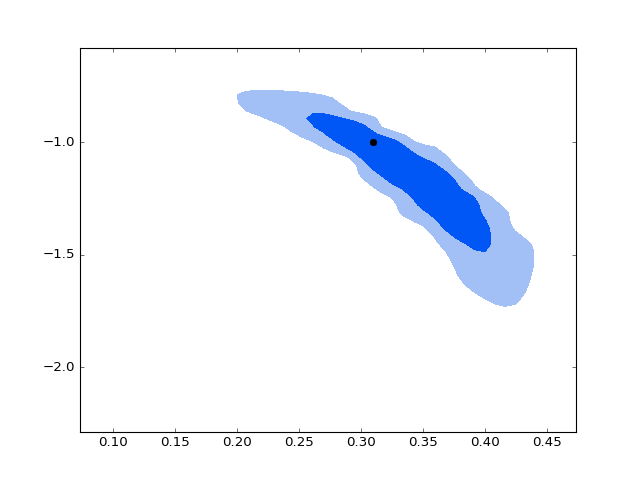

In [18]:
plt.figure()
smth = 3e4
contour_plot.contour(chain1[10000:,:], [0,1], smooth=smth)
plt.plot(fiducial_cos[0], fiducial_cos[1], 'ok')

## Arabian Nights

In [195]:
nz = 5
dat = make_data(998, mu_err=0.2)

z_err = 0.04*(1+dat[:,0])
inds = np.random.choice(np.arange(len(dat)), nz, replace=False)
print(inds)

[330 731 447 723 279]


In [196]:
new_dat = corrupt_redshifts(dat, 0.04, inds=inds)

<IPython.core.display.Javascript object>


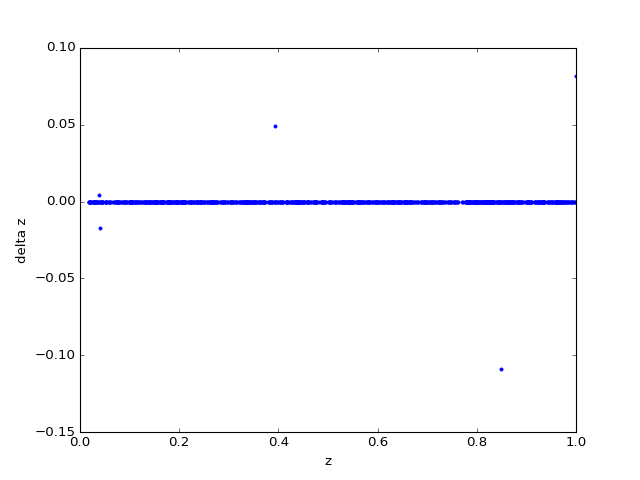

In [197]:
plt.figure()
plt.plot(dat[:, 0], dat[:, 0] - new_dat[:,0], '.b')
#plt.plot(new_dat[:, 0], new_dat[:, 1], '.r')
plt.xlabel('z')
plt.ylabel('delta z')

In [198]:
start_point = np.hstack((fiducial_cos, new_dat[inds,0]))
proposal_spread = np.hstack(([0.05, 0.05, 5.], z_err[inds]))
ndim = 3 + len(inds)
nwalkers = max((2*ndim, 250))

In [199]:
chain1 = run_chain(args=[dat, z_err, inds], ndim=ndim, nwalkers=nwalkers, lnprob=lnprob_zbeams, 
                   start_point=start_point, proposal_spread=proposal_spread)

Time taken 99.26303005218506
Average acceptance ratio 0.4526


In [200]:
chain_std = run_chain(args=[dat]) # Compare with contours of standard method

Time taken 86.21588492393494
Average acceptance ratio 0.54888


<IPython.core.display.Javascript object>


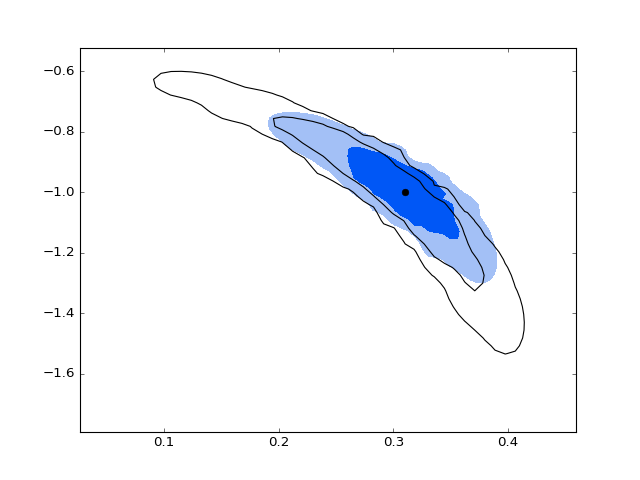

In [201]:
plt.figure()
smth = 8e4
contour_plot.contour(chain1[:,:], [0,1], smooth=smth)
contour_plot.contour(chain_std[:,:], [0,1], smooth=smth, line=True, col='k')
plt.plot(fiducial_cos[0], fiducial_cos[1], 'ok')